# Kaggle competition: Spaceship Titanic classification problem

Andre Moreira, 2023


## Background

This Notebook is prepared in the simplest possible way as a first shot into the competition. Part of the code recycled from the "classical Titanic" competition

## Preamble


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm

from sklearn import preprocessing

# We do not use most of it, here just in case...

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn import ensemble

from sklearn import linear_model

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score

import sklearn.metrics as metrics

In [2]:
# Setting this option will print all collumns of a dataframe
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)

pd.set_option('display.max_rows', None)

In [3]:
# Improve plot resolutions (matplotlib, sns)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150

sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})

This function is to plot the confusion matrix.


In [4]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, cmap ='Greens', annot=True, linewidths = 0.5, 
                linecolor='black',ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']) 
    plt.show() 

In [5]:
# function to get the value of the confusion matrix
def cm_res(Y_t, Y_hat):
    cm_a = confusion_matrix(Y_t, Y_hat)
    tp = cm_a[1][1]
    tn = cm_a[0][0]
    fp = cm_a[0][1]
    fn = cm_a[1][0]
    return tp, tn, fp, fn

In [6]:
# this prepares for the overview, shows the confusion matrix
def overw(X, Y, Y_hat, fitter):
    plot_confusion_matrix(Y,Y_hat)
    a = fitter.score(X, Y)
    b = metrics.f1_score(Y, Y_hat)
    c = metrics.roc_auc_score(Y, Y_hat)
    return a, b, c

## Load and prepare the data


### Training / test data

In [7]:
import os;
os.listdir('/kaggle/input/')

['spaceship-titanic']

In [8]:
# This is the training data
data = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")


# This is the test / prediction data
data_pred = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

In [9]:
data.shape

(8693, 14)

In [10]:
data_pred.shape

(4277, 13)

In [11]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [12]:
# First, copy the data into dataframes that we will use throughout the notebook. In case later we want to "reset", no need to upload the data again.
df = data.copy()
df_pred = data_pred.copy()

#### Encode categorical data

In [13]:
# Store the passager ID in the index
df.set_index("PassengerId", inplace = True)
df_pred.set_index("PassengerId", inplace = True)

In [14]:
df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [15]:
# Extract the target set
Y = df["Transported"].to_numpy(copy = True, dtype = float)
Y

array([0., 1., 0., ..., 1., 0., 1.])

In [16]:
# Convert categorical to one-hot encoding - but first let's check how practical that is
print(len(df["HomePlanet"].unique()))
print(len(df["Cabin"].unique()))
print(len(df["Destination"].unique()))
print(len(df_pred["HomePlanet"].unique()))
print(len(df_pred["Cabin"].unique()))
print(len(df_pred["Destination"].unique()))

4
6561
4
4
3266
4


For the category "Cabin" there too many unique values - we will not one-hot encode them, we will for now drop them.

As for the others: it looks good, not too many unique values per category - so we can proceed with one-hot enconding.

In [17]:
# focus on the columns that we will one-hot encode
df_X = df.drop(columns = ["Cabin"]).loc[:,"HomePlanet":"VRDeck"].copy()
df_X_test = df_pred.drop(columns = ["Cabin"]).loc[:,"HomePlanet":"VRDeck"].copy()

In [18]:
df_X.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
PassengerId,,,,,,,,,,
0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0
0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0
0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0
0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0
0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0


In [19]:
# These are the encoded variables that we will later use for modeling

df_X_num = pd.get_dummies(df_X, dtype=float)
df_X_test_num = pd.get_dummies(df_X_test, dtype=float)

In [20]:
df_X_num.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True
PassengerId,,,,,,,,,,,,,,,,
0001_01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
0002_01,24.0,109.0,9.0,25.0,549.0,44.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
0003_01,58.0,43.0,3576.0,0.0,6715.0,49.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
0003_02,33.0,0.0,1283.0,371.0,3329.0,193.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
0004_01,16.0,303.0,70.0,151.0,565.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


In [21]:
df_X_num.shape

(8693, 16)

#### Familiarize ourselves with the data by looking at distributions, correlation matrix, etc - which variables play the most important role, etc.

In [22]:
# How are the correlations among the variables and target?

df_aux = df_X_num.copy() # create an auxiliary DF for the analysis; must be a copy, otherwise df_X_num is modified
df_aux[["Y"]] = df[["Transported"]].astype(float) # for the correlation analysis, add the target column to this auxiliary DF  
aux = df_aux.corr(numeric_only = True, method = "pearson") # correlation matrix

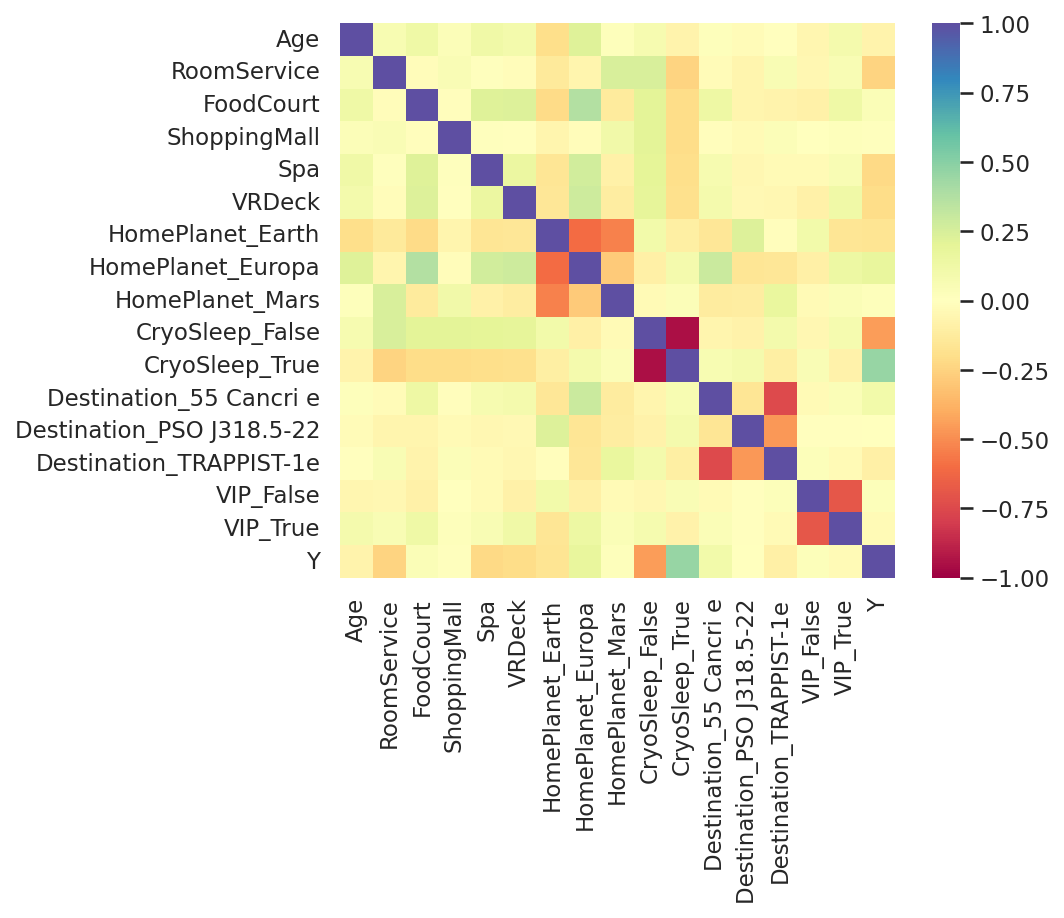

In [23]:
# Plot the matrix as a whole
sns.heatmap(aux, cmap="Spectral", annot=False, square = True,
            vmin=-1, vmax=+1, center = 0)
plt.show()

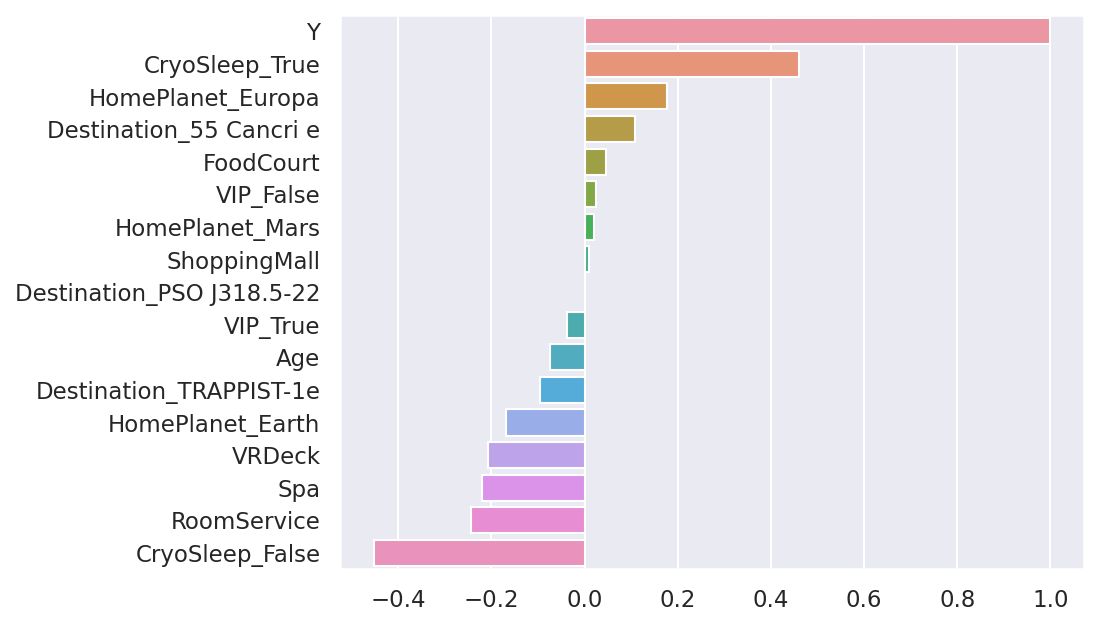

In [24]:
# Look at the correlation between Y and the different variables 

sns.barplot(aux[["Y"]].sort_values(by = "Y", ascending = False).T, orient="h")
plt.show()

The strongest correlation between Y ("Transported") shows with being in cryoSleep or not.

#### Clean up the NaNs

In [25]:
# Are there many NaNs in the encoded variables?

print(df_X_num.isna().sum(), "\n \n")
print(df_X_test_num.isna().sum(), "\n \n")
print("fraction of NaN in df_X_num = ", df_X_num.isna().sum().max()/len(df_X_num), 
      "  fraction of NaN in df_X_test_num = ", df_X_test_num.isna().sum().max()/len(df_X_test_num))

Age                          179
RoomService                  181
FoodCourt                    183
ShoppingMall                 208
Spa                          183
VRDeck                       188
HomePlanet_Earth               0
HomePlanet_Europa              0
HomePlanet_Mars                0
CryoSleep_False                0
CryoSleep_True                 0
Destination_55 Cancri e        0
Destination_PSO J318.5-22      0
Destination_TRAPPIST-1e        0
VIP_False                      0
VIP_True                       0
dtype: int64 
 

Age                           91
RoomService                   82
FoodCourt                    106
ShoppingMall                  98
Spa                          101
VRDeck                        80
HomePlanet_Earth               0
HomePlanet_Europa              0
HomePlanet_Mars                0
CryoSleep_False                0
CryoSleep_True                 0
Destination_55 Cancri e        0
Destination_PSO J318.5-22      0
Destination_TRAPPIST-1e   

In [26]:
# In a first (and simplified approach), we substitute the NaN values for the average values in each column.
# This may be enough because each column has a much larger number of variables than the highest number of NaN 

for i in df_X_num.columns[df_X_num.isnull().any(axis=0)]:     #---Applying Only on variables with NaN values
    df_X_num[i].fillna(df_X_num[i].mean(),inplace=True)

for i in df_X_test_num.columns[df_X_test_num.isnull().any(axis=0)]:     #---Applying Only on variables with NaN values
    df_X_test_num[i].fillna(df_X_test_num[i].mean(),inplace=True)

In [27]:
# Double check
print("fraction of NaN in df_X_num = ", df_X_num.isna().sum().max()/len(df_X_num), 
      "  fraction of NaN in df_X_test_num = ", df_X_test_num.isna().sum().max()/len(df_X_test_num))

fraction of NaN in df_X_num =  0.0   fraction of NaN in df_X_test_num =  0.0


In [28]:
df_X_num.shape[0]

8693

In [29]:
len(Y)

8693

Importantly, X and Y have the same number of rows ("same shape" in this context).

### Rescaling, folds, prepare for modeling after cleaning up the data

In [30]:
# In this dataset, what is the probability of transportation? 
Y.mean()

0.5036236051995858

In [31]:
# Prepare the variable set, which we will call X
# Center and scale X so we can feed it into the models without worrying about unit variance.

X = preprocessing.StandardScaler().fit(df_X_num).transform(df_X_num)
X[0:2]

array([[ 0.70943692, -0.34058987, -0.28731404, -0.29081703, -0.27666342,
        -0.26902263, -1.06061696,  1.754795  , -0.50366411,  0.77348028,
        -0.73277002, -0.51101319, -0.31748665,  0.68531265,  0.22019607,
        -0.15306307],
       [-0.33671733, -0.1753636 , -0.28166908, -0.24896783,  0.2115053 ,
        -0.23019432,  0.94284745, -0.56986714, -0.50366411,  0.77348028,
        -0.73277002, -0.51101319, -0.31748665,  0.68531265,  0.22019607,
        -0.15306307]])

We split the data into training and testing data using the  function  <code>train_test_split</code>.

The training data and test data is assigned to the following labels:

<code>X_train, X_test, Y_train, Y_test</code>


In [32]:
# Here we split 80/20, use as global variables when calling functions
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
print ('Train set:', X_train.shape,  Y_train.shape)
print ('Test set:', X_test.shape,  Y_test.shape)

Train set: (6954, 16) (6954,)
Test set: (1739, 16) (1739,)


In [33]:
# random state in the train_test_split so that the average survival rate is +- the same as in the full dataset
print(Y.mean())
print(Y_train.mean())
print(Y_test.mean())

0.5036236051995858
0.498561978717285
0.5238642898217366


In [34]:
# define a function that we will use to fit the models to the data
def fitting(model, params):
    model_cv = GridSearchCV(model, params, cv = 10, verbose = 1)
    model_cv.fit(X_train, Y_train)
    print("tuned hpyerparameters :(best parameters) ",model_cv.best_params_)
    print("accuracy :",model_cv.best_score_) # note that this is what is used to measure success in this Kaggle competition
    return(model_cv)

At this point, we feed Y and X into different models, train and test them, in the end we compare the models to choose the one that we will use to submit our predictions

In [35]:
# get a list ready to save scores
score_list = [["Model", "Score", "F1", "AUC"]]

## Modelling

### Logistic Regression

In [36]:
lr = LogisticRegression()
parameters ={"C":[0.05,1.0,1.5],'penalty':["l2"], 'solver':['lbfgs']} # l1 lasso l2 ridge

logreg_cv = fitting(lr, parameters)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.7845848838170844


Calculate the accuracy on the test data using the method <code>score</code>:


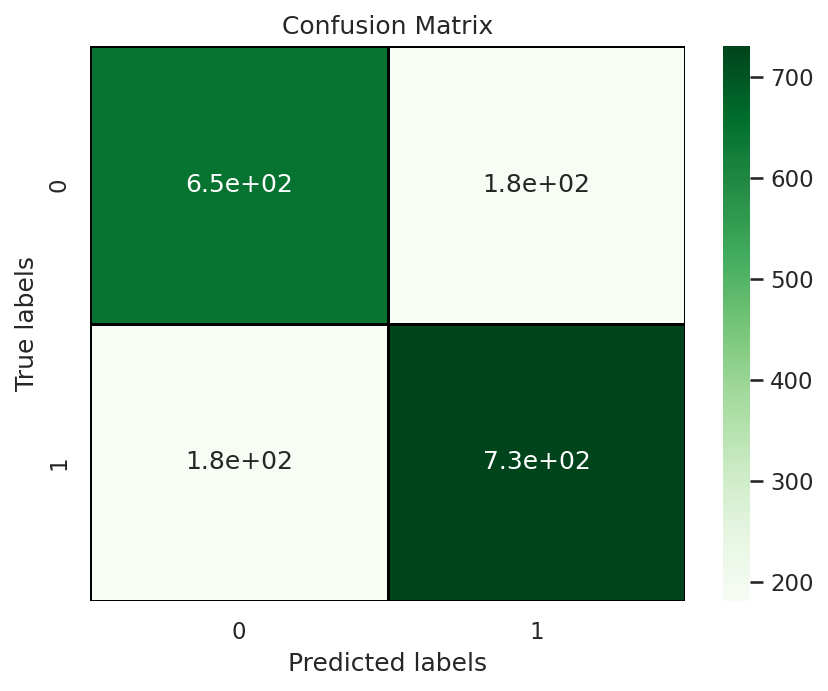

score =  0.7918343875790684   F1 =  0.8013172338090011 AUC =  0.791359099996288


In [37]:
# Store the score
scr, F1, auc = overw(X_test, Y_test, logreg_cv.predict(X_test), logreg_cv)
score_list = score_list + [["LR", scr, F1, auc]]
print("score = ", scr, "  F1 = ", F1, "AUC = ", auc)

### Random Forest

In [38]:
rf = ensemble.RandomForestClassifier(n_jobs = -1)
parameters ={} # l1 lasso l2 ridge

rf_cv = fitting(rf, parameters)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
tuned hpyerparameters :(best parameters)  {}
accuracy : 0.7850124038700075


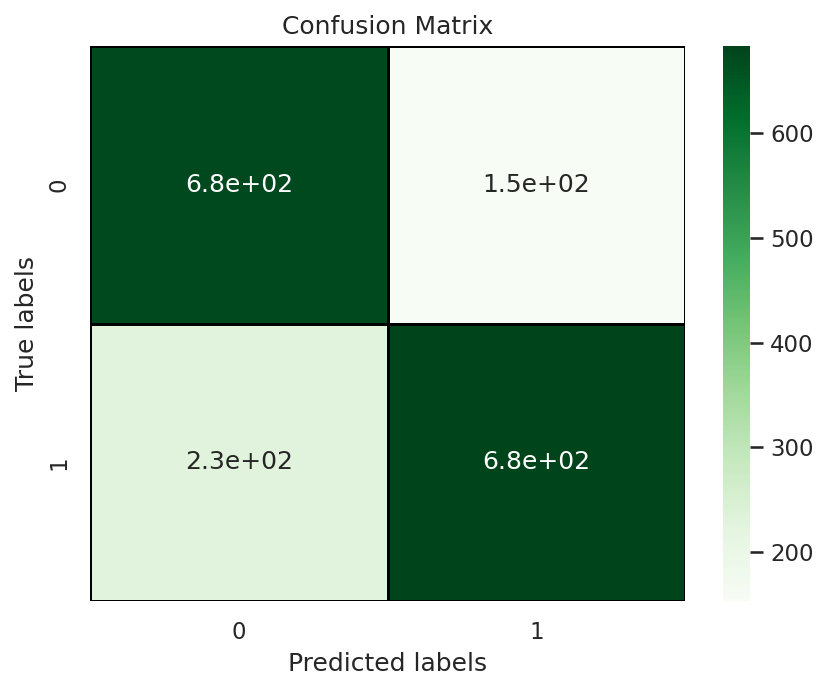

score =  0.7809085681426107   F1 =  0.7819118488838008 AUC =  0.7824714837970697


In [39]:
# Store the score
scr, F1, auc = overw(X_test, Y_test, rf_cv.predict(X_test), rf_cv)
score_list = score_list + [["RF", scr, F1, auc]]
print("score = ", scr, "  F1 = ", F1, "AUC = ", auc)

### Compare the models


In [40]:
Report = pd.DataFrame(score_list[1:], columns = score_list[0])
Report

,Model,Score,F1,AUC
0,LR,0.791834,0.801317,0.791359
1,RF,0.780909,0.781912,0.782471


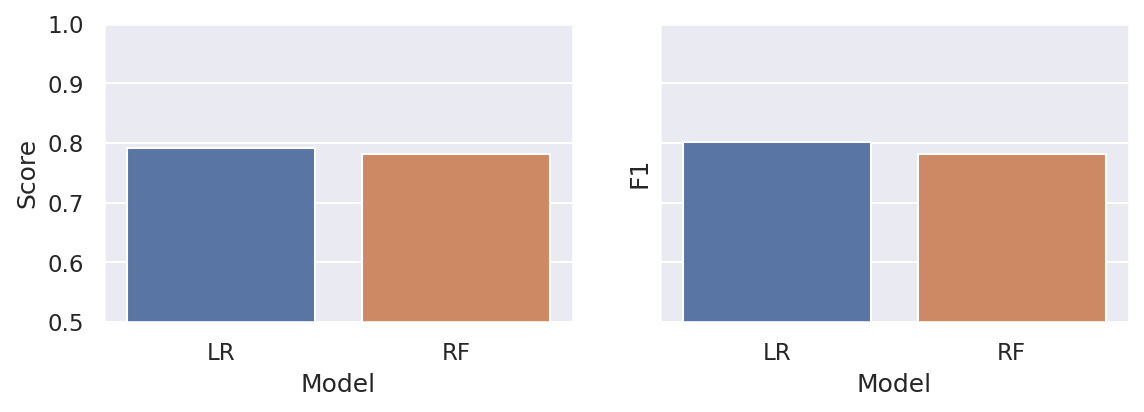

In [41]:
fig, axa = plt.subplots(ncols = 2, figsize = (8,3), sharey = True)
fig.tight_layout(pad=2.0)

sns.barplot(data=Report, x="Model", y="F1", ax = axa[1])

sns.barplot(data=Report, x="Model", y="Score", ax = axa[0])

axa[0].set_ylim(0.5, 1)

plt.show()

## Prediction

In [42]:
# Like we did before: center and scale it so we can feed it into the models without worrying about unit variance.
X_p = preprocessing.StandardScaler().fit(df_X_test_num).transform(df_X_test_num)
X_p[0:2]

array([[-0.11822162, -0.36477954, -0.29135159, -0.31985918, -0.27455773,
        -0.25156055,  0.94338172, -0.55313127, -0.52531386, -1.26992369,
         1.33044268, -0.49473362, -0.31586164,  0.66849659,  0.2015753 ,
        -0.13268938],
       [-0.68860136, -0.36477954, -0.28538513, -0.31985918,  2.28300781,
        -0.25156055,  0.94338172, -0.55313127, -0.52531386,  0.78744889,
        -0.75162953, -0.49473362, -0.31586164,  0.66849659,  0.2015753 ,
        -0.13268938]])

In [43]:
len(X_p)

4277

### Predictions from the models

In [44]:
# survey a model, get its prediction ready to save for upload
def pred(mod, data_p, X_p):
    Y_p = mod.predict(X_p)
    # prepare the DF with the predictions
    subm = pd.concat([pd.DataFrame(data_p, columns=["PassengerId"]), pd.DataFrame({'Transported': Y_p})], axis=1)
    print("Transported rates:")
    print("Total ensemble = ", Y.mean())
    print("Train = ", Y_train.mean())
    print("Test = ", Y_test.mean())
    print("Prediction = ", Y_p.mean())
    return(subm)

In [45]:
sub_LR = pred(logreg_cv, data_pred, X_p)

Transported rates:
Total ensemble =  0.5036236051995858
Train =  0.498561978717285
Test =  0.5238642898217366
Prediction =  0.5195230301613281


In [46]:
sub_RF = pred(rf_cv, data_pred, X_p)

Transported rates:
Total ensemble =  0.5036236051995858
Train =  0.498561978717285
Test =  0.5238642898217366
Prediction =  0.4470423193827449


In [47]:
# choose a model to generate a submission

subm = sub_LR  # model
subm.replace(to_replace = {1: True, 0: False}, inplace = True) # make sure 0 and 1 are now False and True
number = "2" # number of the this "trial", e.g. 20

subm.to_csv(f"submission_{number}.csv", header = True, index = False)